# Time series forecasting with RNNs

- Source: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

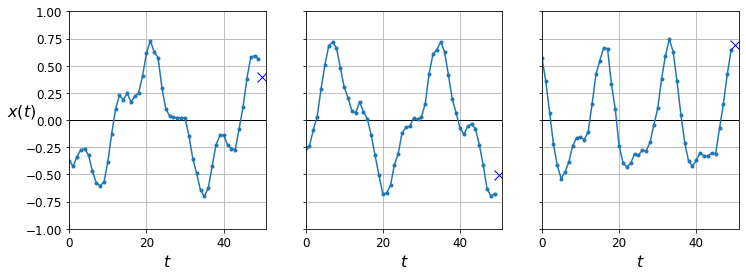

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

## Baselines
- Naive
- Fully connected NN

OBS: Predicting the next value only

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

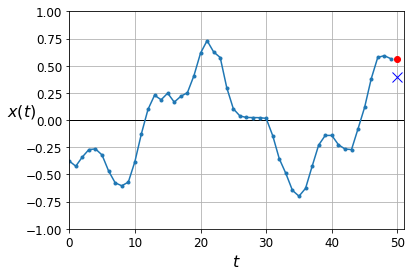

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 141us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/20
7000/7000 [==============================] - 1s 93us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/20
7000/7000 [==============================] - 1s 84us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/20
7000/7000 [==============================] - 0s 64us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/20
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0103 - val_loss: 0.0097
Epoch 6/20
7000/7000 [==============================] - 0s 68us/sample - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 1s 72us/sample - loss: 0.0079 - val_loss: 0.0078
Epoch 8/20
7000/7000 [==============================] - 0s 60us/sample - loss: 0.0072 - val_loss: 0.0073
Epoch 9/20
7000/7000 [==============================] - 0s 67us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 

In [10]:
# model.evaluate(X_valid, y_valid)

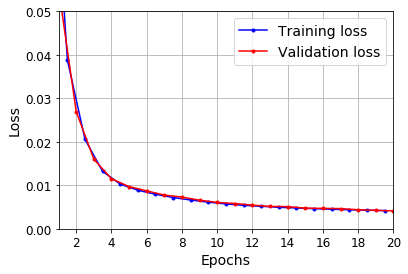

In [9]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

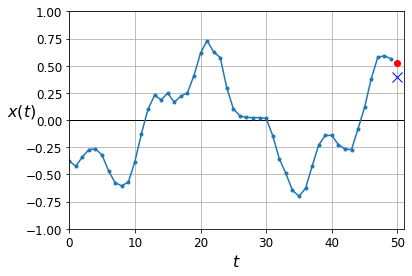

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [11]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [12]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [13]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [14]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [16]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

# LSTM

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0311 - last_time_step_mse: 0.0125 - 

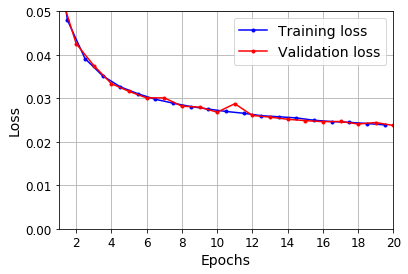

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [19]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

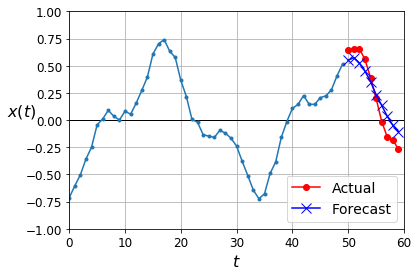

In [20]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0745 - last_time_step_mse: 0.0668 - val_loss: 0.0526 - val_last_time_step_mse: 0.0413
Epoch 2/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.0478 - last_time_step_mse: 0.0369 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0420 - last_time_step_mse: 0.0306 - val_loss: 0.0395 - val_last_time_step_mse: 0.0275
Epoch 4/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0375 - last_time_step_mse: 0.0250 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0327 - last_time_step_mse: 0.0178 - val_loss: 0.0311 - val_last_time_step_mse: 0.0156
Epoch 6/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0309 - last_time_step_mse: 0.0157 - 

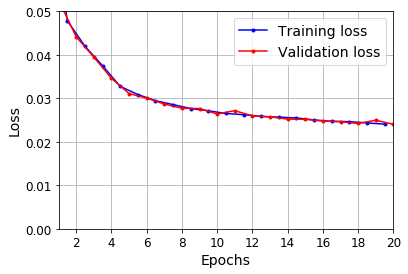

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [23]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

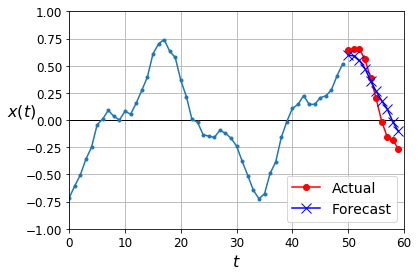

In [24]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 1D Conv layer

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0686 - last_time_step_mse: 0.0609 - val_loss: 0.0485 - val_last_time_step_mse: 0.0406
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0420 - last_time_step_mse: 0.0346 - val_loss: 0.0370 - val_last_time_step_mse: 0.0290
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0341 - last_time_step_mse: 0.0262 - val_loss: 0.0307 - val_last_time_step_mse: 0.0215
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0282 - last_time_step_mse: 0.0183 - val_loss: 0.0258 - val_last_time_step_mse: 0.0149
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0239 - val_last_time_step_mse: 0.0130
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0236 - last_time_step_mse: 0.0128 - val_l

# WaveNet

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0668 - last_time_step_mse: 0.0541 - val_loss: 0.0361 - val_last_time_step_mse: 0.0225
Epoch 2/20
7000/7000 [==============================] - 5s 740us/sample - loss: 0.0320 - last_time_step_mse: 0.0196 - val_loss: 0.0309 - val_last_time_step_mse: 0.0195
Epoch 3/20
7000/7000 [==============================] - 5s 747us/sample - loss: 0.0278 - last_time_step_mse: 0.0159 - val_loss: 0.0268 - val_last_time_step_mse: 0.0147
Epoch 4/20
7000/7000 [==============================] - 5s 746us/sample - loss: 0.0258 - last_time_step_mse: 0.0140 - val_loss: 0.0249 - val_last_time_step_mse: 0.0127
Epoch 5/20
7000/7000 [==============================] - 4s 608us/sample - loss: 0.0247 - last_time_step_mse: 0.0131 - val_loss: 0.0241 - val_last_time_step_mse: 0.0123
Epoch 6/20
7000/7000 [==============================] - 4s 598us/sample - loss: 0.0238 - last_time_step_mse: 0.012

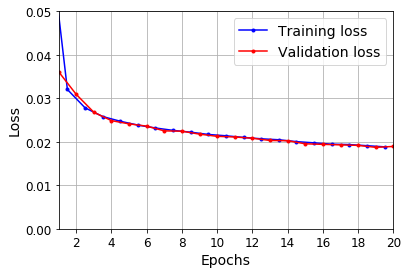

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [32]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

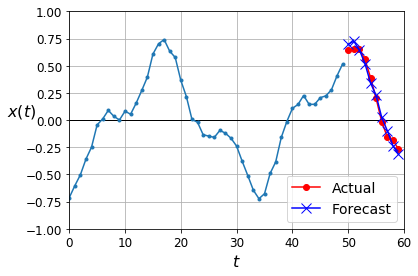

In [33]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Original WaveNet (paper)

In [27]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
    
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [29]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1300 - last_time_step_mse: 0.1256 - val_loss: 0.1230 - val_last_time_step_mse: 0.1200
Epoch 2/20
7000/7000 [==============================] - 7s 993us/sample - loss: 0.1221 - last_time_step_mse: 0.1177 - val_loss: 0.1217 - val_last_time_step_mse: 0.1188
Epoch 3/20
7000/7000 [==============================] - 6s 799us/sample - loss: 0.1215 - last_time_step_mse: 0.1172 - val_loss: 0.1213 - val_last_time_step_mse: 0.1185
Epoch 4/20
7000/7000 [==============================] - 6s 855us/sample - loss: 0.1212 - last_time_step_mse: 0.1169 - val_loss: 0.1210 - val_last_time_step_mse: 0.1182
Epoch 5/20
7000/7000 [==============================] - 6s 840us/sample - loss: 0.1210 - last_time_step_mse: 0.1167 - val_loss: 0.1209 - val_last_time_step_mse: 0.1181
Epoch 6/20
7000/7000 [==============================] - 6s 821us/sample - loss: 0.1208 - last_time_step_mse: 0.116